# CMU Movie data

## Initial data inspection
We will first try to provide a first generic inspection of the CMU movie dataset we decided to work on.

In [1]:
import pandas as pd
import numpy as np
import re
import json
from src.utils.data_utils import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

### Load Data
The dataset is divided in 3 parts, the characters, the movies and the plots of the movies.

In [2]:
character_data, movie_data, plot_data = load_data()

### Characters dataset
Let's first have a look to the character dataset.

In [3]:
print(f'There are {character_data.shape[0]} characters with {character_data.shape[1]} features for each.')

There are 450669 characters with 13 features for each.


In [4]:
character_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


We can note that the actor ethnicity need to be transform to readable value (for now, it looks to be freebase id).

Let's now see if we have a lot of missing data. We will also check that we don't have duplicated rows.

In [5]:
print("Pourcentage of null rows in the characters dataset for each features:")
print(character_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the characters dataset for each features:
wikipedia_movie_id         0.0
freebase_movie_id          0.0
movie_release_date         2.2
character_name            57.2
actor_dob                 23.6
actor_gender              10.1
actor_height              65.6
actor_ethnicity           76.5
actor_name                 0.3
actor_age_at_release      35.1
character_actor_map_id     0.0
character_id              57.2
actor_id                   0.2
dtype: float64


In [6]:
print(f"Duplicated rows: {character_data.duplicated().sum()}")

Duplicated rows: 0


We see that we miss a lot of character names/ids, actor heights, actor ethnicity and actor age at release.

### Movies dataset
Let's now have a look to the movies dataset.

In [7]:
print(f'There are {movie_data.shape[0]} movies with {movie_data.shape[1]} features for each.')

There are 81741 movies with 9 features for each.


In [8]:
movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


We can note that the languages, countries and genres need to be preprocessed (for now dictionnary with id->readablename).
We can also imagine to add a column movie_release_year.

Let's now see if we have a lot of missing data. We will also verify that we dont' have duplicated rows.

In [9]:
print("Pourcentage of null rows in the movies dataset for each features:")
print(movie_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the movies dataset for each features:
wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     8.4
box_office_revenue    89.7
runtime               25.0
languages              0.0
countries              0.0
genres                 0.0
dtype: float64


In [10]:
print(f"Duplicated rows: {movie_data.duplicated().sum()}")

Duplicated rows: 0


Ouch! We only have box office revenue for 10% of our movies, that's not a good new since it's a key feature in our research problematic, we will need to fix this. Except this we can note that we miss 25% of the runtime information, we could try to improve this. Same for the movie release data. About the languages, countries and genres, we note that they are dictionnaries meaning that we first need to preprocess them a bit (for example transforming them to a list) to then be able to see the pourcentage of missing data. We will do it now:

In [11]:
# Extract the readable values for 'languages', 'countries', and 'genres' columns. Also clean the language column.

movie_data['languages'] = movie_data['languages'].apply(lambda x: extract_values(x, clean_func=clean_language))
movie_data['countries'] = movie_data['countries'].apply(lambda x: extract_values(x)) 
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_values(x))  

We can now have a look to the missing data:

In [12]:
# Calculate the number of None (NaN) values for each column
none_languages = movie_data['languages'].isna().mean()
none_countries = movie_data['countries'].isna().mean()
none_genres = movie_data['genres'].isna().mean()

# Print the counts of None (NaN) values
print(f"Number of None values in 'languages': {none_languages}")
print(f"Number of None values in 'countries': {none_countries}")
print(f"Number of None values in 'genres': {none_genres}")

Number of None values in 'languages': 0.16963335413073
Number of None values in 'countries': 0.09975410136895806
Number of None values in 'genres': 0.04383357189170673


This looks ok overall.

### Plot summary dataset
Let's now have a look to the plot summaries dataset.

In [13]:
print(f'There are {plot_data.shape[0]} plot summaries with {plot_data.shape[1]} features for each.')

There are 42303 plot summaries with 2 features for each.


In [14]:
plot_data.head(2)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Let's see if we have some rows that are invalid (no summary or wikipedia id).

In [15]:
print("Pourcentage of null rows in the plot summaries dataset:")
print(plot_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the plot summaries dataset:
wikipedia_movie_id    0.0
summary               0.0
dtype: float64


Good new, we have nothing missing here :)

## Data completion + first preprocessing
Before going deeper to the analysis, we want to already fix some problems we pointed out.

Movies:
- A lot of box office revenus missing
- We can also imagine to add a column movie_release_year.

Characters:
- We see that we miss a lot of character names/ids, actor heights, actor ethnicity and actor age at release.
- We first note that we need to preprocess the actor ethnicity that look to be a freebase id.

### Movies problems

Let's first to get more data on box office results to decrease the number of missing data we have for now. To do this, we will merge the current dataset with differents other datasets that contain box office results (and also runtime since we have 25% of missing). Let's first add the Wikidata dataset.

In [16]:
# Import dataset from wikidata
with open('data/wikidata.json', 'r') as f:
    wikidata_json = json.load(f)
wikidata = pd.DataFrame(wikidata_json)

# We rename some columns for merging after
wikidata['box_office_revenue'] = pd.to_numeric(wikidata['box_office'], errors='coerce') 
wikidata['movie_name'] = wikidata['title'].astype(str)
wikidata.drop(columns=['box_office', 'title'], inplace=True)

wikidata.head(2)

,item,freebase_id,IMDb_ID,box_office_revenue,movie_name
0,http://www.wikidata.org/entity/Q223139,/m/0jqd3,tt0053125,5740000.0,North by Northwest
1,http://www.wikidata.org/entity/Q223139,/m/0jqd3,tt0053125,9840000.0,North by Northwest


Amazing, we have the freebase id and the box office, we just now need to merge them with the current dataframe.
We will first merge on the freebase ID and then on the movie title.

In [17]:
movies_wikidata_merged, before_missing, after_missing = merge_for_completion(movie_data, wikidata, "freebase_movie_id", "freebase_id", "box_office_revenue", merge_strategy='mean')

In [18]:
# Print the before and after missing values
print(f"Box office results missing values before merge (on freebase ID) with wikidata: {before_missing:.2f}")
print(f"Box office results missing values after merge (on freebase ID) with wikidata: {after_missing:.2f}")

Box office results missing values before merge (on freebase ID) with wikidata: 0.90
Box office results missing values after merge (on freebase ID) with wikidata: 0.87


In [19]:
movies_wikidata_merged, before_missing, after_missing = merge_for_completion(movies_wikidata_merged, wikidata, "movie_name", "movie_name", "box_office_revenue", merge_strategy='prioritize_first')

In [20]:
# Print the before and after missing values
print(f"Box office results missing values before merge (on title) with wikidata: {before_missing:.2f}")
print(f"Box office results missing values after merge (on title) with wikidata: {after_missing:.2f}")

Box office results missing values before merge (on title) with wikidata: 0.87
Box office results missing values after merge (on title) with wikidata: 0.84


It's not a big improvement but it's a good start. Let's now do the same with another dataset named 'The Movies Dataset' from https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download. Since we don't have the freebase ID, we will directly merge on the movie title. Note that we will also try to complete the missing data on runtime since this dataset has it.

In [21]:
# Load the new dataset (and rename some columns)
movies_dataset = pd.read_csv('data/movies_metadata.csv')
movies_dataset['box_office_revenue'] = pd.to_numeric(movies_dataset['revenue'], errors='coerce') 
movies_dataset.head(2)

C:\Users\floco\AppData\Local\Temp\ipykernel_41968\2722644251.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_dataset = pd.read_csv('data/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,box_office_revenue
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,373554033.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,262797249.0


In [22]:
movies_wikidata_merged, before_missing, after_missing = merge_for_completion(movies_wikidata_merged, movies_dataset, "movie_name", "original_title", "box_office_revenue", merge_strategy='prioritize_first')

In [23]:
# Print the before and after missing values
print(f"Box office results missing values before merge (on title) with The Movies Dataset: {before_missing:.2f}")
print(f"Box office results missing values after merge (on title) with The Movies Dataset: {after_missing:.2f}")

Box office results missing values before merge (on title) with The Movies Dataset: 0.84
Box office results missing values after merge (on title) with The Movies Dataset: 0.60


Good improvement! Let's do the same for the runtime:

In [24]:
movies_wikidata_merged, before_missing, after_missing = merge_for_completion(movies_wikidata_merged, movies_dataset, "movie_name", "original_title", "runtime", merge_strategy='prioritize_first')

In [25]:
# Print the before and after missing values
print(f"Runtime results missing values before merge (on title) with The Movies Dataset: {before_missing:.2f}")
print(f"Runtime results missing values after merge (on title) with The Movies Dataset: {after_missing:.2f}")

Runtime results missing values before merge (on title) with The Movies Dataset: 0.23
Runtime results missing values after merge (on title) with The Movies Dataset: 0.16


Small improvement but we take it. Let's try to use another dataset to complete...

In [26]:
movie_data_completed = movies_wikidata_merged.copy()

## Deeper analysis
Now that our data is more complete, we can do a more in deep analysis.

### Character dataset 

Let's first analyse our character dataset. We will start with a summary of the statistics of the numerical features.

In [27]:
character_data.describe()

,wikipedia_movie_id,actor_height,actor_age_at_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


Let's print their distributions:

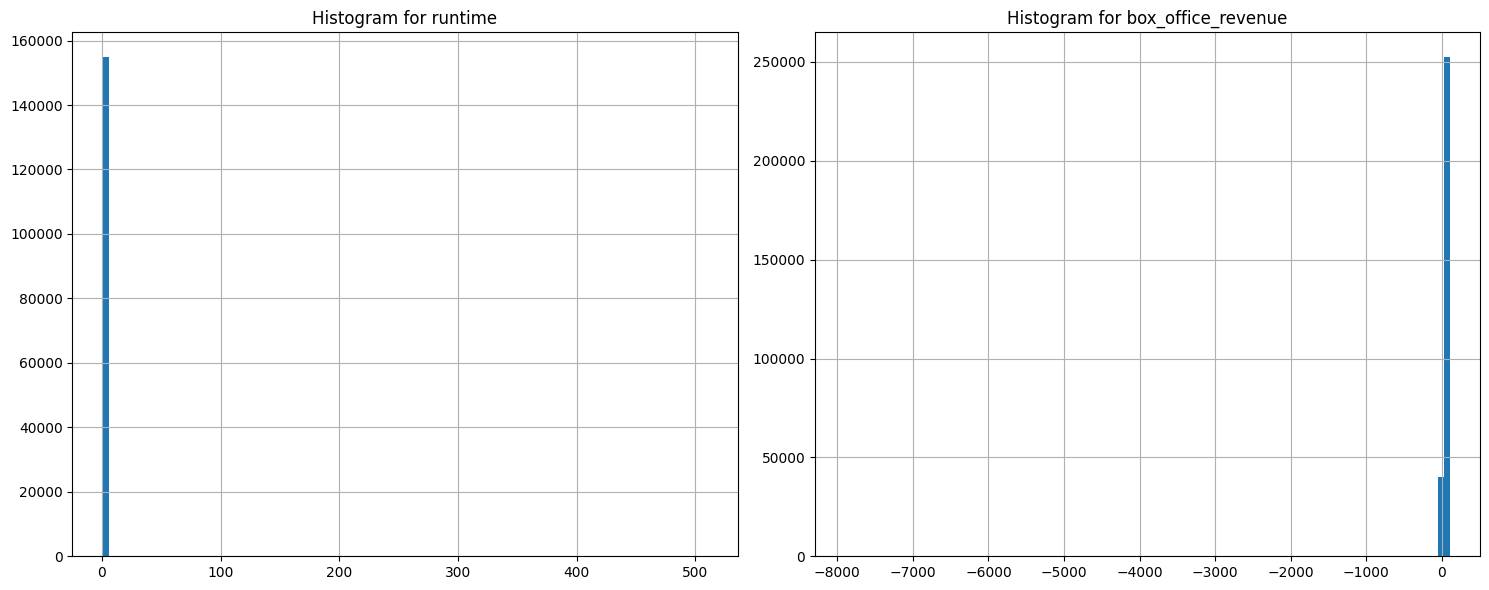

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for the runtime
character_data["actor_height"].hist(bins=100, ax=axes[0])
axes[0].set_title("Histogram for runtime")

# Histogram for the box office results
character_data["actor_age_at_release"].hist(bins=100, ax=axes[1])
axes[1].set_title("Histogram for box_office_revenue")

plt.tight_layout()
plt.show()


Not really ideal because of the outliers and the spread of the data, let's use a log transformation.

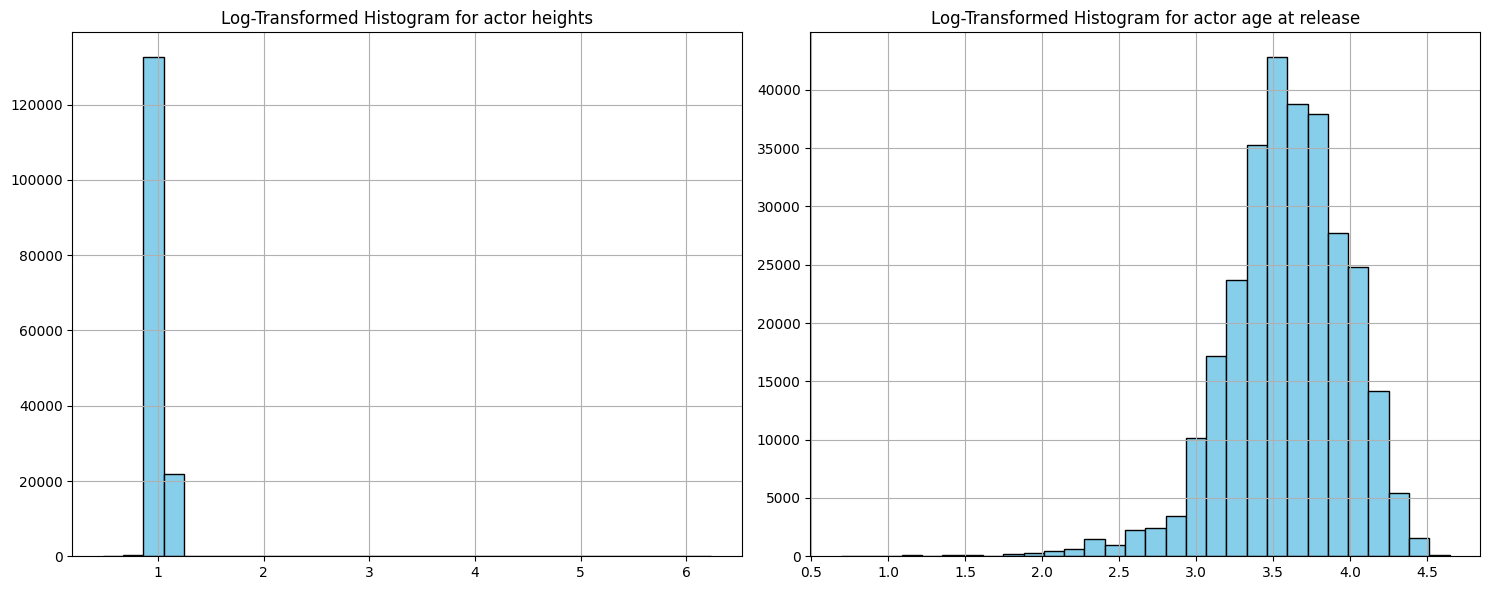

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Apply log transformation only on positive values for "actor_height"
positive_heights = character_data["actor_height"][character_data["actor_height"] > 0]
np.log1p(positive_heights).hist(bins=30, ax=axes[0])
axes[0].set_title("Log-Transformed Histogram for actor heights")

# Apply log transformation only on positive values for "actor_age_at_release"
positive_ages = character_data["actor_age_at_release"][character_data["actor_age_at_release"] > 0]
np.log1p(positive_ages).hist(bins=30, ax=axes[1])
axes[1].set_title("Log-Transformed Histogram for actor age at release")

plt.tight_layout()
plt.show()


Let's now print some box plots (also with log transformation).

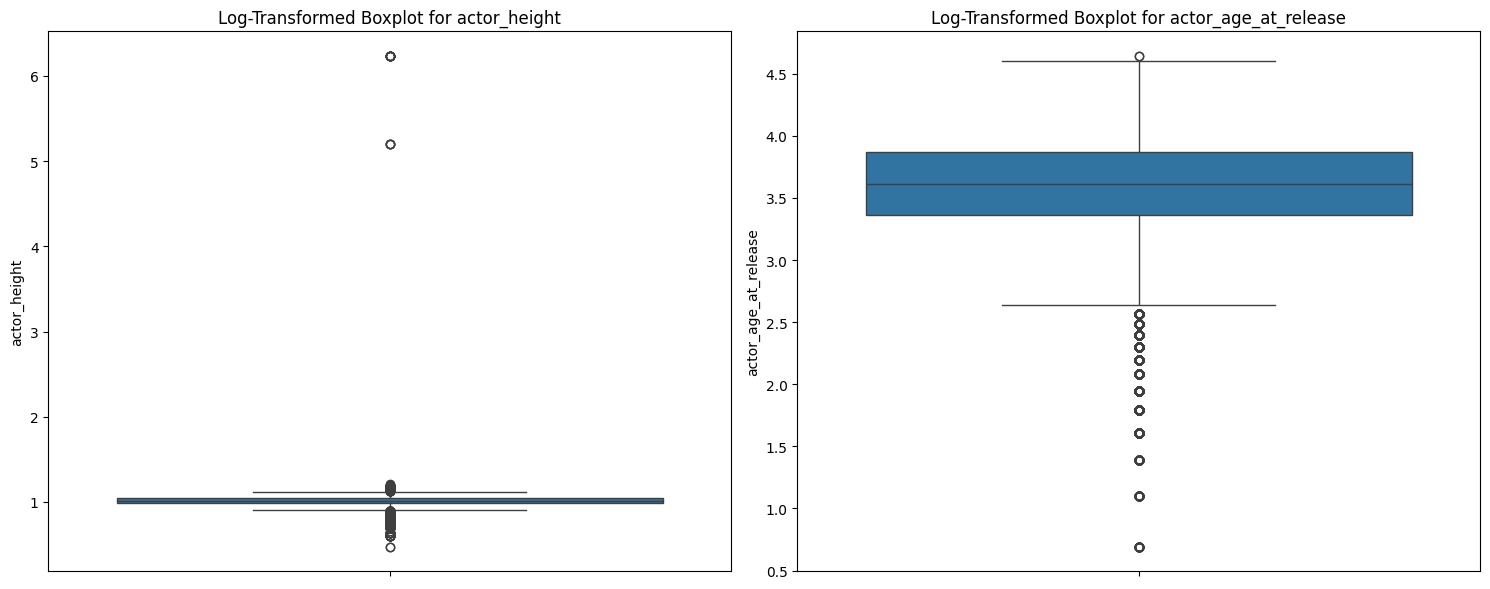

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Filter out non-positive values and apply log transformation for "actor_height"
positive_heights = character_data["actor_height"][character_data["actor_height"] > 0]
sns.boxplot(data=np.log1p(positive_heights), ax=axes[0])
axes[0].set_title("Log-Transformed Boxplot for actor_height")

# Filter out non-positive values and apply log transformation for "actor_age_at_release"
positive_ages = character_data["actor_age_at_release"][character_data["actor_age_at_release"] > 0]
sns.boxplot(data=np.log1p(positive_ages), ax=axes[1])
axes[1].set_title("Log-Transformed Boxplot for actor_age_at_release")

plt.tight_layout()
plt.show()


TODO Continue analysis, categorical data...

### Movies dataset 

Let's now analyse our movies dataset. We will start with a summary of the statistics of the numerical features.

In [28]:
movie_data_completed.describe()

,wikipedia_movie_id,box_office_revenue,runtime
count,1.153680e+05,6.001300e+04,9.671900e+04
mean,1.586021e+07,7.583216e+07,1.078824e+02
std,1.117325e+07,2.734158e+08,3.470951e+03
min,3.300000e+02,0.000000e+00,0.000000e+00
25%,5.429460e+06,0.000000e+00,8.200000e+01
50%,1.475877e+07,9.000000e+05,9.400000e+01
75%,2.572119e+07,4.123080e+07,1.090000e+02
max,3.750192e+07,3.168000e+10,1.079281e+06


TODO: Comment this, also note the max of runtime very big

Let's print their distributions (except for the wikipedia id):

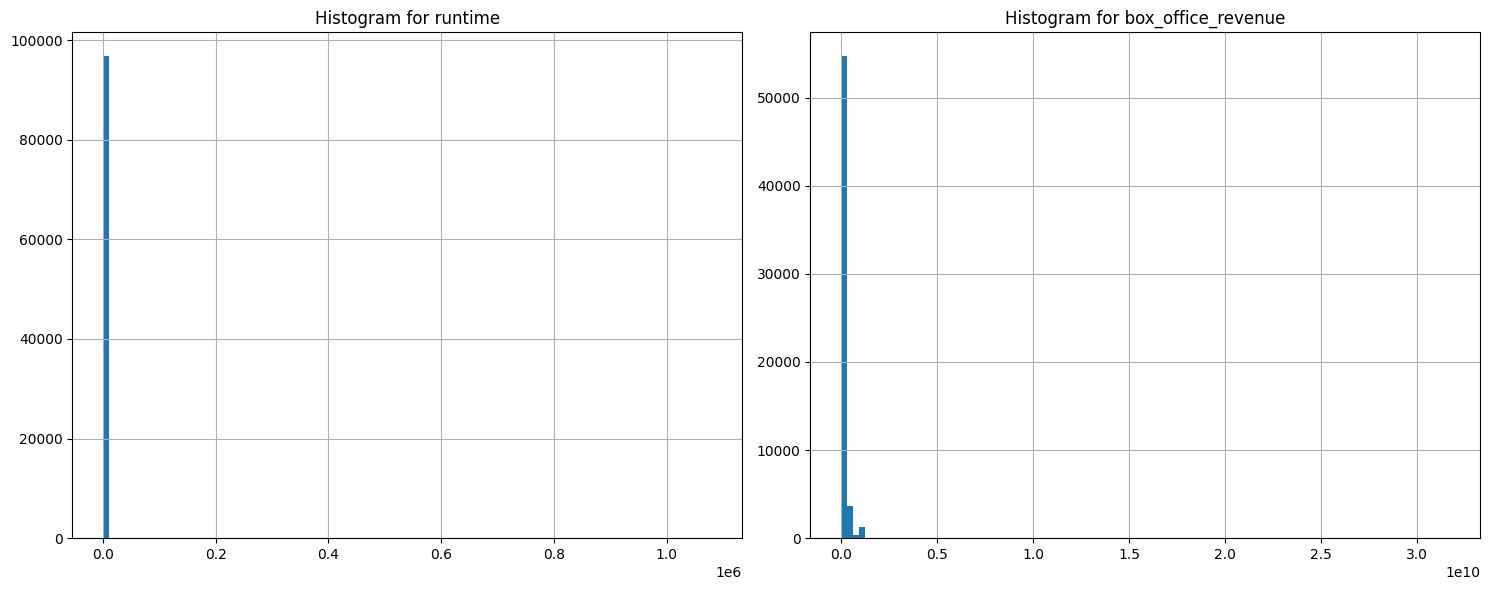

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for the runtime
movie_data_completed["runtime"].hist(bins=100, ax=axes[0])
axes[0].set_title("Histogram for runtime")

# Histogram for the box office results
movie_data_completed["box_office_revenue"].hist(bins=100, ax=axes[1])
axes[1].set_title("Histogram for box_office_revenue")

plt.tight_layout()
plt.show()


Not really ideal because of the outliers and the spread of the data, let's use a log transformation.

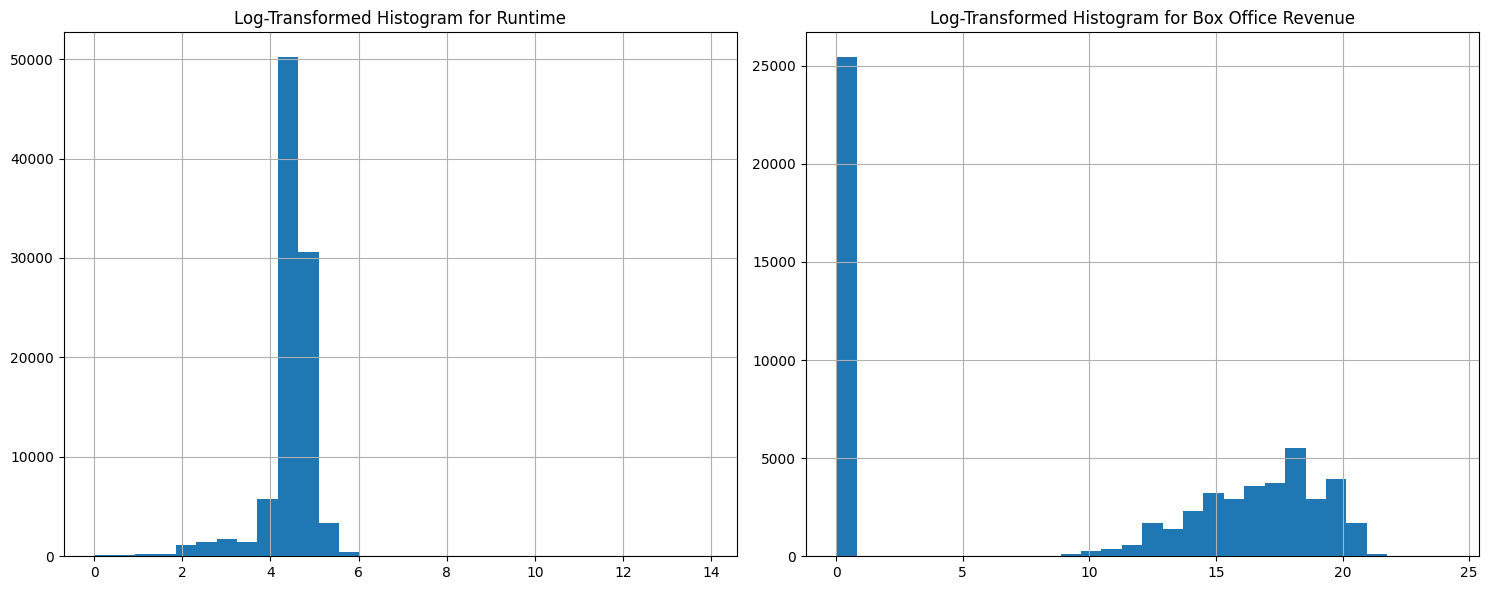

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for the runtime
np.log1p(movie_data_completed["runtime"]).hist(bins=30, ax=axes[0])
axes[0].set_title("Log-Transformed Histogram for Runtime")

# Histogram for the box office results (log-transformed)
np.log1p(movie_data_completed["box_office_revenue"]).hist(bins=30, ax=axes[1])
axes[1].set_title("Log-Transformed Histogram for Box Office Revenue")

plt.tight_layout()
plt.show()

Let's now print some box plots (also with log transformation).

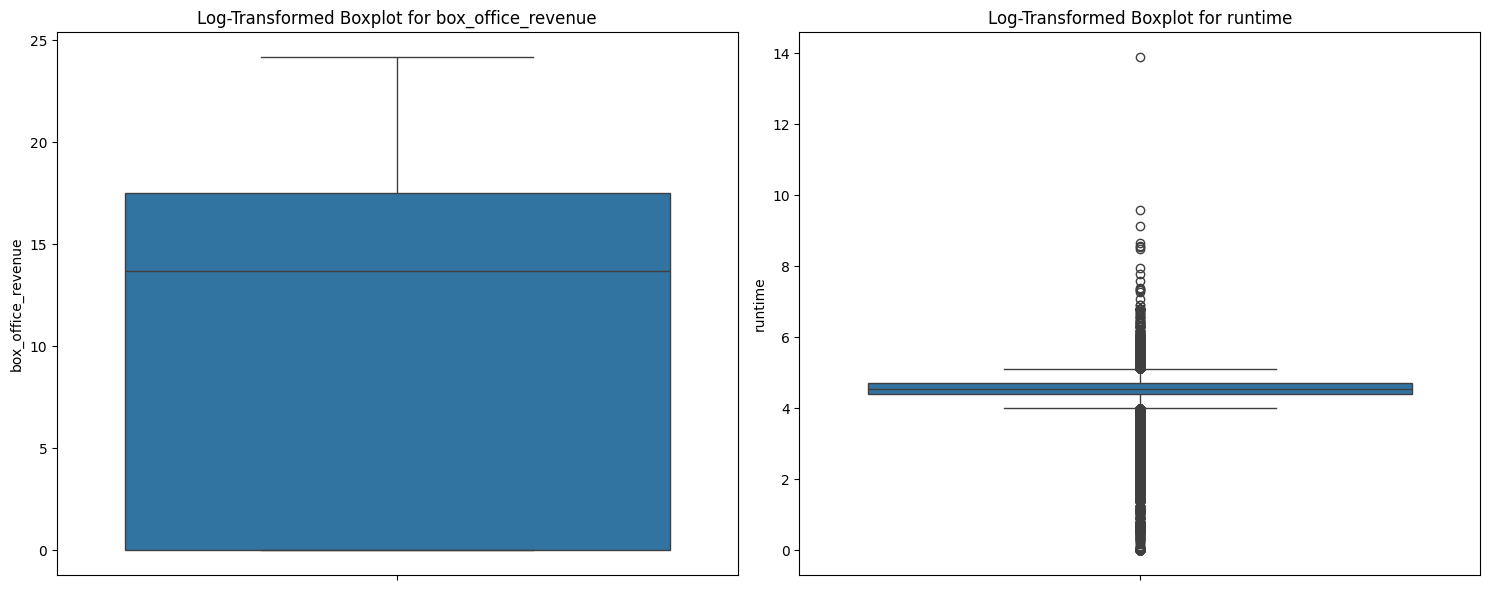

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for the log-transformed box_office_revenue
sns.boxplot(data=np.log1p(movie_data_completed["box_office_revenue"]), ax=axes[0])
axes[0].set_title("Log-Transformed Boxplot for box_office_revenue")

# Boxplot for the log-transformed runtime
sns.boxplot(data=np.log1p(movie_data_completed["runtime"]), ax=axes[1])
axes[1].set_title("Log-Transformed Boxplot for runtime")

plt.tight_layout()
plt.show()


TODO: MAYBE TRY TO DO A BETTER plot for box office

We can now have a look to the categorical features:

In [31]:
#TODO: SOME COUNT PLOTS FOR CATEGORICAL